In [16]:
import argparse
import sys
import os
import json
import pprint
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import torch
from collections import Counter
import matplotlib

In [2]:
BASE_DIR = "/Users/katemarg/PycharmProjects/temporal_robustness_evaluation"
DATA_DIR = os.path.join(BASE_DIR, 'data')
CKPT_DIR = os.path.join(BASE_DIR, 'pretrained_models')
RES_DIR = os.path.join(BASE_DIR, 'new_results')
MLT_CSV_DIR = os.path.join(RES_DIR, 'multi_token', 'csv_files')
LOG_DIR = os.path.join(BASE_DIR, 'new_logs')
CACHE_DIR = os.path.join(BASE_DIR, 'cached')

# model = "twitter-roberta-base-2019-90m"
# seed = 42
# N = 100
# M = 5
# topk = 20

models = [
            'cardiffnlp/twitter-roberta-base-2019-90m',
            'cardiffnlp/twitter-roberta-base-mar2020',
            'cardiffnlp/twitter-roberta-base-jun2020',
            'cardiffnlp/twitter-roberta-base-sep2020',
            'cardiffnlp/twitter-roberta-base-dec2020',
            'cardiffnlp/twitter-roberta-base-mar2021',
            'cardiffnlp/twitter-roberta-base-jun2021',
            'cardiffnlp/twitter-roberta-base-sep2021',
            'cardiffnlp/twitter-roberta-base-dec2021',
            # 'cardiffnlp/twitter-roberta-base-2021-124m',
            'cardiffnlp/twitter-roberta-base-mar2022',
            'cardiffnlp/twitter-roberta-base-jun2022'
        ]
quarters = [
    '2019-Q2', '2019-Q3', '2019-Q4',
    '2020-Q1', '2020-Q2', '2020-Q3', '2020-Q4',
    '2021-Q1', '2021-Q2', '2021-Q3', '2021-Q4',
    '2022-Q1', '2022-Q2'

]
# exp_str = "{}_dynamic-templama_2019-1-1_to_2022-6-31_per_quarter_multi_token_42_10_100".format(model.split("-")[-1])

In [3]:
def change_model_column(results_df):
    results_df['model'] = results_df['model'].apply(lambda x: x.split('-')[-1])
    results_df.loc[results_df['model'] == "90m", 'model'] = "2019-Q4"
    results_df.loc[results_df['model'] == "mar2020", 'model'] = "2020-Q1"
    results_df.loc[results_df['model'] == "jun2020", 'model'] = "2020-Q2"
    results_df.loc[results_df['model'] == "sep2020", 'model'] = "2020-Q3"
    results_df.loc[results_df['model'] == "dec2020", 'model'] = "2020-Q4"
    results_df.loc[results_df['model'] == "mar2021", 'model'] = "2021-Q1"
    results_df.loc[results_df['model'] == "jun2021", 'model'] = "2021-Q2"
    results_df.loc[results_df['model'] == "sep2021", 'model'] = "2021-Q3"
    results_df.loc[results_df['model'] == "dec2021", 'model'] = "2021-Q4"
    results_df.loc[results_df['model'] == "mar2022", 'model'] = "2022-Q1"
    results_df.loc[results_df['model'] == "jun2022", 'model'] = "2022-Q2"
    return results_df

In [4]:
def boxplot_vis(label, df):
    sns.barplot(x='year', y=label, data=df, hue='model', palette="rocket")
    sns.despine(offset=10, trim=True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
    plt.title("Dynamic TempLAMA / multi token / {}".format(label))
    plt.xticks(rotation=45)
    plt.savefig('plots/{}_per_quarter.png'.format(label), bbox_inches = 'tight',edgecolor='white')

In [5]:
def plot_for_split(df_to_plot, split):
    fig, axs = plt.subplots(3,1, figsize=(12, 20), sharex=True)
    sns.barplot(x='quarter', y="avg_f1_macro", data=df_to_plot, hue='model', palette="rocket", ax=axs[0], ci=None)
    sns.barplot(x='quarter', y="avg_rouge", data=df_to_plot, hue='model', palette="rocket", ax=axs[1], ci=None)
    sns.barplot(x='quarter', y="avg_bert_score", data=df_to_plot, hue='model', palette="rocket", ax=axs[2])
    # sns.barplot(x='year', y="P@20", data=results_df, hue='model', palette="rocket", ax=axs[3])
    # sns.barplot(x='year', y="P@50", data=results_df, hue='model', palette="rocket", ax=axs[4])
    # sns.barplot(x='year', y="P@100", data=results_df, hue='model', palette="rocket", ax=axs[5])
    [ax.get_legend().remove() for ax in axs[:-1]]
    [ax.set_xlabel("") for ax in axs[:-1]]
    axs[-1].set_xlabel("Test set for {} split (per quarter)".format(split))
    plt.legend(bbox_to_anchor=(1.05,1.8), loc='upper left', borderaxespad=0, prop={'size': 22}, title='TimeLMs')
    for ax in axs:
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(16)
    plt.rcParams.update({'font.size': 30})
    plt.xticks(rotation=45)
    plt.savefig('plots/multi_token_{}_all_models.png'.format(split), bbox_inches = 'tight',edgecolor='white',dpi=500)

# This notebook analyses the results with the *multi-token* test data.

# (1) Overall performance

## We first provide the overall performance of each TimeLM on average for the last 4 years (for all fine-grained splits combined)

In [6]:
# Load all splits
splits = ["updated", "new", "deleted", "unchanged"]
full_df = pd.DataFrame()

for split in splits:
    for model in models:
        if split == "unchanged":
            for quarter in quarters:
                exp_str = "{}_dynamic-templama_2019-1-1_to_2022-6-31_per_quarter_multi_token_42_10_100".format(model.split("-")[-1])
                filepath = "{}_{}_{}.csv".format(exp_str, split, quarter)
                try:
                    _df = pd.read_csv(os.path.join(MLT_CSV_DIR, filepath))
                    full_df = full_df.append(_df, ignore_index=True)
                except:
                    print(model, quarter)
        else:
            exp_str = "{}_dynamic-templama_2019-1-1_to_2022-6-31_per_quarter_multi_token_42_10_100".format(model.split("-")[-1])
            filepath = "{}_{}.csv".format(exp_str, split)
            try:
                _df = pd.read_csv(os.path.join(MLT_CSV_DIR, filepath))
                full_df = full_df.append(_df, ignore_index=True)
            except:
                print(model)
        


/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = full_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = full_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = full_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = full_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = full_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = full_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

cardiffnlp/twitter-roberta-base-mar2020 2021-Q1
cardiffnlp/twitter-roberta-base-jun2020 2020-Q3


/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = full_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = full_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = full_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = full_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = full_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = full_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = full_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = full_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = full_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

cardiffnlp/twitter-roberta-base-sep2021 2021-Q2


/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = full_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = full_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  full_df = full_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/3853119409.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.con

In [7]:
# keep only columns we care about
full_df = change_model_column(full_df)[['model', 'quarter', 'size', 'split', 
                                              'avg_f1_micro', 'avg_f1_macro',
                                             'avg_rouge', 'avg_bleu_uni', 'avg_bert_score']]
full_df

,model,quarter,size,split,avg_f1_micro,avg_f1_macro,avg_rouge,avg_bleu_uni,avg_bert_score
0,2019-Q4,2019-Q2,174,updated,0.0168,0.0146,0.0459,0.0479,0.8776
1,2019-Q4,2019-Q3,259,updated,0.0104,0.0076,0.0548,0.0679,0.8768
2,2019-Q4,2019-Q4,157,updated,0.0000,0.0000,0.0325,0.0376,0.8755
3,2019-Q4,2020-Q1,311,updated,0.0138,0.0111,0.0316,0.0349,0.8741
4,2019-Q4,2020-Q2,94,updated,0.0064,0.0038,0.0303,0.0268,0.8734
...,...,...,...,...,...,...,...,...,...
564,2022-Q2,2021-Q2,10608,unchanged,0.0185,0.0142,0.0717,0.0714,0.8784
565,2022-Q2,2021-Q3,10302,unchanged,0.0187,0.0141,0.0745,0.0733,0.8786
566,2022-Q2,2021-Q4,10372,unchanged,0.0181,0.0137,0.0726,0.0721,0.8785
567,2022-Q2,2022-Q1,10344,unchanged,0.0182,0.0139,0.0721,0.0710,0.8784


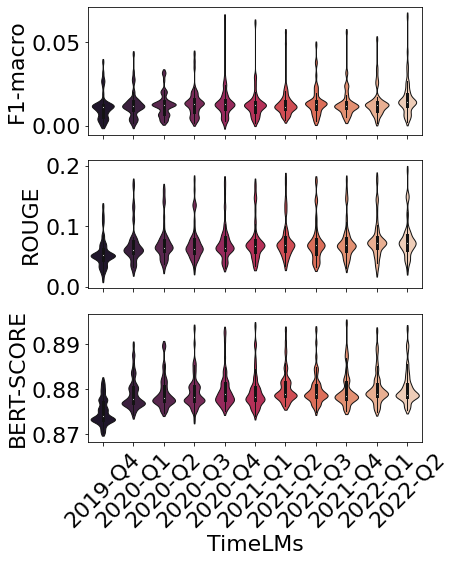

In [18]:
# fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1, figsize=(8, 13), sharex=True)
fig, (ax0, ax1, ax2) = plt.subplots(3,1, figsize=(6, 8), sharex=True)
sns.violinplot(data=full_df, y='avg_f1_macro', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax0)
sns.violinplot(data=full_df, y='avg_rouge', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax1)
# sns.violinplot(data=full_df, y='avg_bleu_uni', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax2)
sns.violinplot(data=full_df, y='avg_bert_score', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax2)
plt.xticks(rotation=45)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax0.set_xlabel("")
ax0.set_ylabel("F1-macro")
ax1.set_xlabel("")
ax1.set_ylabel("ROUGE")
# ax2.set_xlabel("")
ax2.set_ylabel("BERT-SCORE")
ax2.set_xlabel("TimeLMs")
matplotlib.rcParams.update({'font.size': 18})
# ax0.set_title('Performance of TimeLMs *on average* across the last 4 years (2019-2022) \n for multi-token evaluation.')
plt.savefig('plots/Results_avg_last4years_quarter_multi_token.png', bbox_inches = 'tight', dpi=500)

In [19]:
full_df

,model,quarter,size,split,avg_f1_micro,avg_f1_macro,avg_rouge,avg_bleu_uni,avg_bert_score
0,2019-Q4,2019-Q2,174,updated,0.0168,0.0146,0.0459,0.0479,0.8776
1,2019-Q4,2019-Q3,259,updated,0.0104,0.0076,0.0548,0.0679,0.8768
2,2019-Q4,2019-Q4,157,updated,0.0000,0.0000,0.0325,0.0376,0.8755
3,2019-Q4,2020-Q1,311,updated,0.0138,0.0111,0.0316,0.0349,0.8741
4,2019-Q4,2020-Q2,94,updated,0.0064,0.0038,0.0303,0.0268,0.8734
...,...,...,...,...,...,...,...,...,...
564,2022-Q2,2021-Q2,10608,unchanged,0.0185,0.0142,0.0717,0.0714,0.8784
565,2022-Q2,2021-Q3,10302,unchanged,0.0187,0.0141,0.0745,0.0733,0.8786
566,2022-Q2,2021-Q4,10372,unchanged,0.0181,0.0137,0.0726,0.0721,0.8785
567,2022-Q2,2022-Q1,10344,unchanged,0.0182,0.0139,0.0721,0.0710,0.8784


## (2) Updated Split

/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1444452051.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1444452051.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1444452051.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1444452051.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

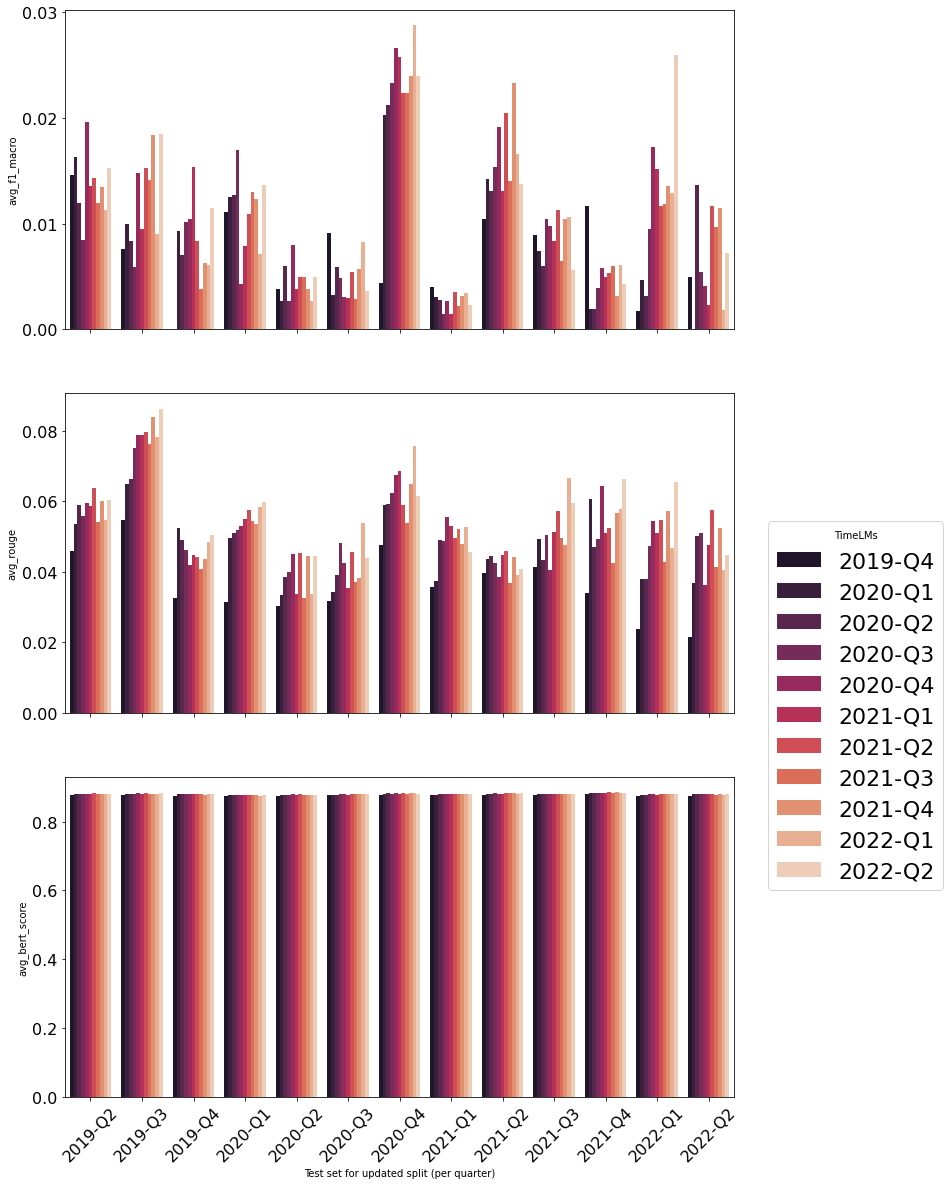

In [9]:
# Load all updated csv files with unchanged split
split = "updated"
updated_df = pd.DataFrame()

for model in models:
    exp_str = "{}_dynamic-templama_2019-1-1_to_2022-6-31_per_quarter_multi_token_42_10_100".format(model.split("-")[-1])
    filepath = "{}_{}.csv".format(exp_str, split)
    try:
        _df = pd.read_csv(os.path.join(MLT_CSV_DIR, filepath))
        updated_df = updated_df.append(_df, ignore_index=True)
    except:
        print(model)

# keep only columns we care about
updated_df = change_model_column(updated_df)[['model', 'quarter', 'size', 'split', 
                                              'avg_f1_micro', 'avg_f1_macro',
                                             'avg_rouge', 'avg_bleu_uni', 'avg_bert_score']]

df_to_plot = updated_df.copy()
plot_for_split(df_to_plot, split)

In [10]:
# fig, axs = plt.subplots(3,1, figsize=(12, 20), sharex=True)
# sns.barplot(x='quarter', y="avg_f1_macro", data=df_to_plot, hue='model', palette="rocket", ax=axs[0], ci=None)
# sns.barplot(x='quarter', y="avg_rouge", data=df_to_plot, hue='model', palette="rocket", ax=axs[1], ci=None)
# sns.barplot(x='quarter', y="avg_bert_score", data=df_to_plot, hue='model', palette="rocket", ax=axs[2])
# # sns.barplot(x='year', y="P@20", data=results_df, hue='model', palette="rocket", ax=axs[3])
# # sns.barplot(x='year', y="P@50", data=results_df, hue='model', palette="rocket", ax=axs[4])
# # sns.barplot(x='year', y="P@100", data=results_df, hue='model', palette="rocket", ax=axs[5])
# [ax.get_legend().remove() for ax in axs[:-1]]
# [ax.set_xlabel("") for ax in axs[:-1]]
# axs[-1].set_xlabel("Test set for {} split (per quarter)".format(split))
# plt.legend(bbox_to_anchor=(1.05,1.8), loc='upper left', borderaxespad=0, prop={'size': 22}, title='TimeLMs')
# for ax in axs:
#     for label in (ax.get_xticklabels() + ax.get_yticklabels()):
#         label.set_fontsize(16)
# plt.rcParams.update({'font.size': 30})
# plt.xticks(rotation=45)
# plt.savefig('plots/multi_token_{}_all_models.png'.format(split), bbox_inches = 'tight',edgecolor='white',dpi=500)
# # plt.show()

## (3) New Split

/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1261869161.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1261869161.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1261869161.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  new_df = new_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1261869161.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat in

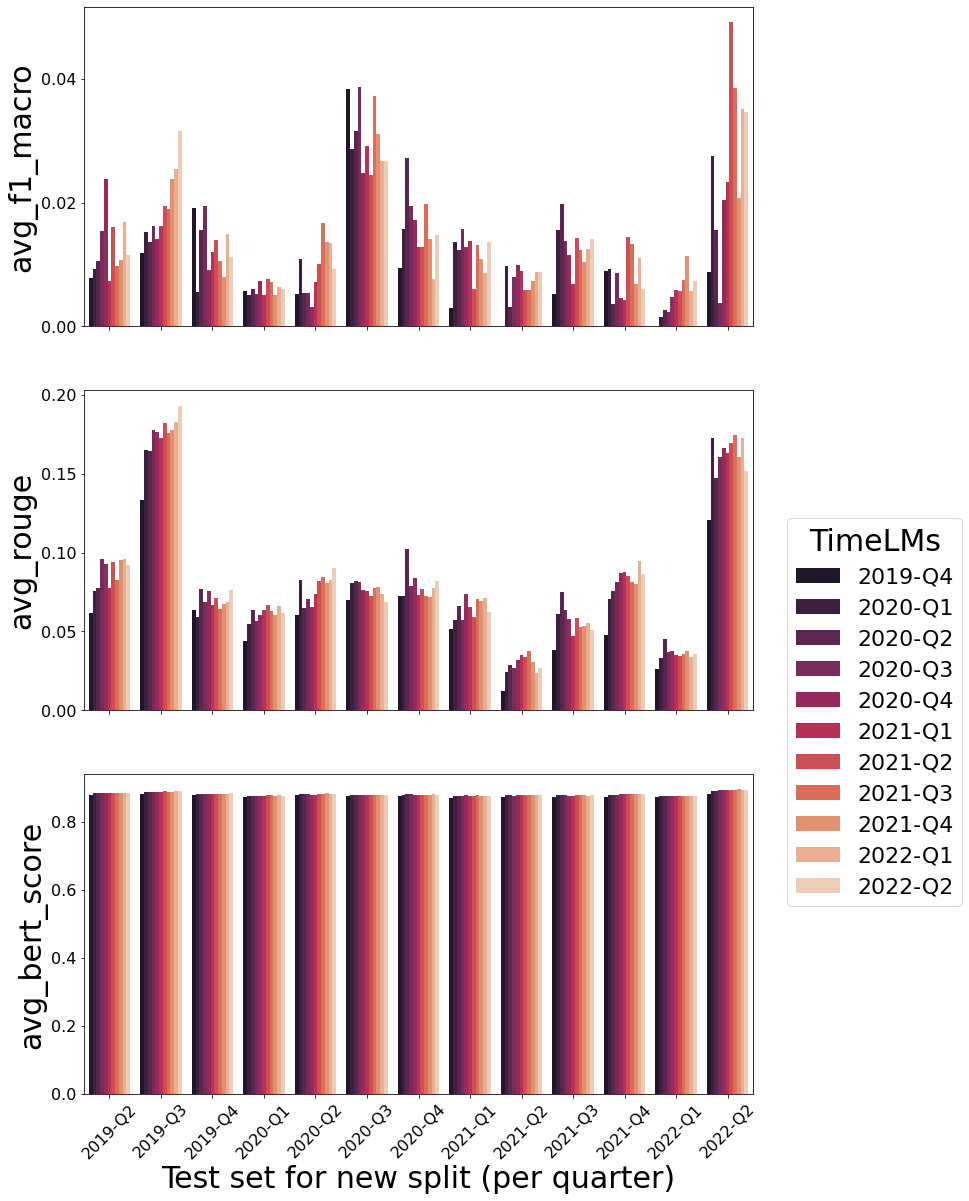

In [11]:
# Load all updated csv files with unchanged split
split = "new"
new_df = pd.DataFrame()

for model in models:
    exp_str = "{}_dynamic-templama_2019-1-1_to_2022-6-31_per_quarter_multi_token_42_10_100".format(model.split("-")[-1])
    filepath = "{}_{}.csv".format(exp_str, split)
    try:
        _df = pd.read_csv(os.path.join(MLT_CSV_DIR, filepath))
        new_df = new_df.append(_df, ignore_index=True)
    except:
        print(model)

# keep only columns we care about
new_df = change_model_column(new_df)[['model', 'quarter', 'size', 'split', 
                                              'avg_f1_micro', 'avg_f1_macro',
                                             'avg_rouge', 'avg_bleu_uni', 'avg_bert_score']]

df_to_plot = new_df.copy()
plot_for_split(df_to_plot, split)

## (4) Deleted Split

/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/2900002905.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deleted_df = deleted_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/2900002905.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deleted_df = deleted_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/2900002905.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  deleted_df = deleted_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/2900002905.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

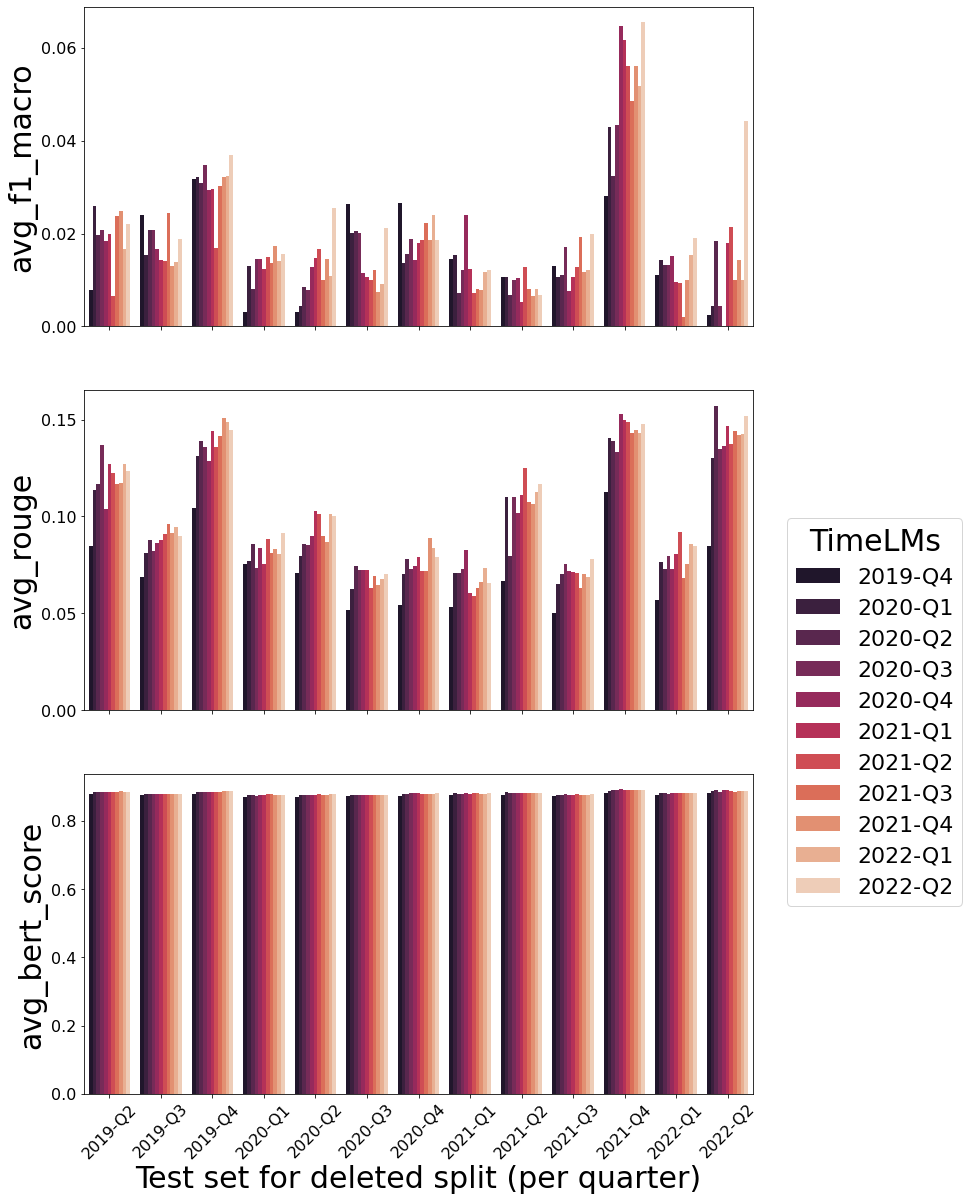

In [12]:
# Load all updated csv files with unchanged split
split = "deleted"
deleted_df = pd.DataFrame()

for model in models:
    exp_str = "{}_dynamic-templama_2019-1-1_to_2022-6-31_per_quarter_multi_token_42_10_100".format(model.split("-")[-1])
    filepath = "{}_{}.csv".format(exp_str, split)
    try:
        _df = pd.read_csv(os.path.join(MLT_CSV_DIR, filepath))
        deleted_df = deleted_df.append(_df, ignore_index=True)
    except:
        print(model)

# keep only columns we care about
deleted_df = change_model_column(deleted_df)[['model', 'quarter', 'size', 'split', 
                                              'avg_f1_micro', 'avg_f1_macro',
                                             'avg_rouge', 'avg_bleu_uni', 'avg_bert_score']]

df_to_plot = deleted_df.copy()
plot_for_split(df_to_plot, split)

## (5) Unchanged Split

/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1377514311.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1377514311.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1377514311.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1377514311.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

cardiffnlp/twitter-roberta-base-mar2020 2021-Q1
cardiffnlp/twitter-roberta-base-jun2020 2020-Q3


/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1377514311.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1377514311.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1377514311.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1377514311.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

cardiffnlp/twitter-roberta-base-sep2021 2021-Q2


/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1377514311.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1377514311.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1377514311.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  updated_df = updated_df.append(_df, ignore_index=True)
/var/folders/k7/bmn9n_v5383b9njft4lk4w8c0000gr/T/ipykernel_2774/1377514311.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future versi

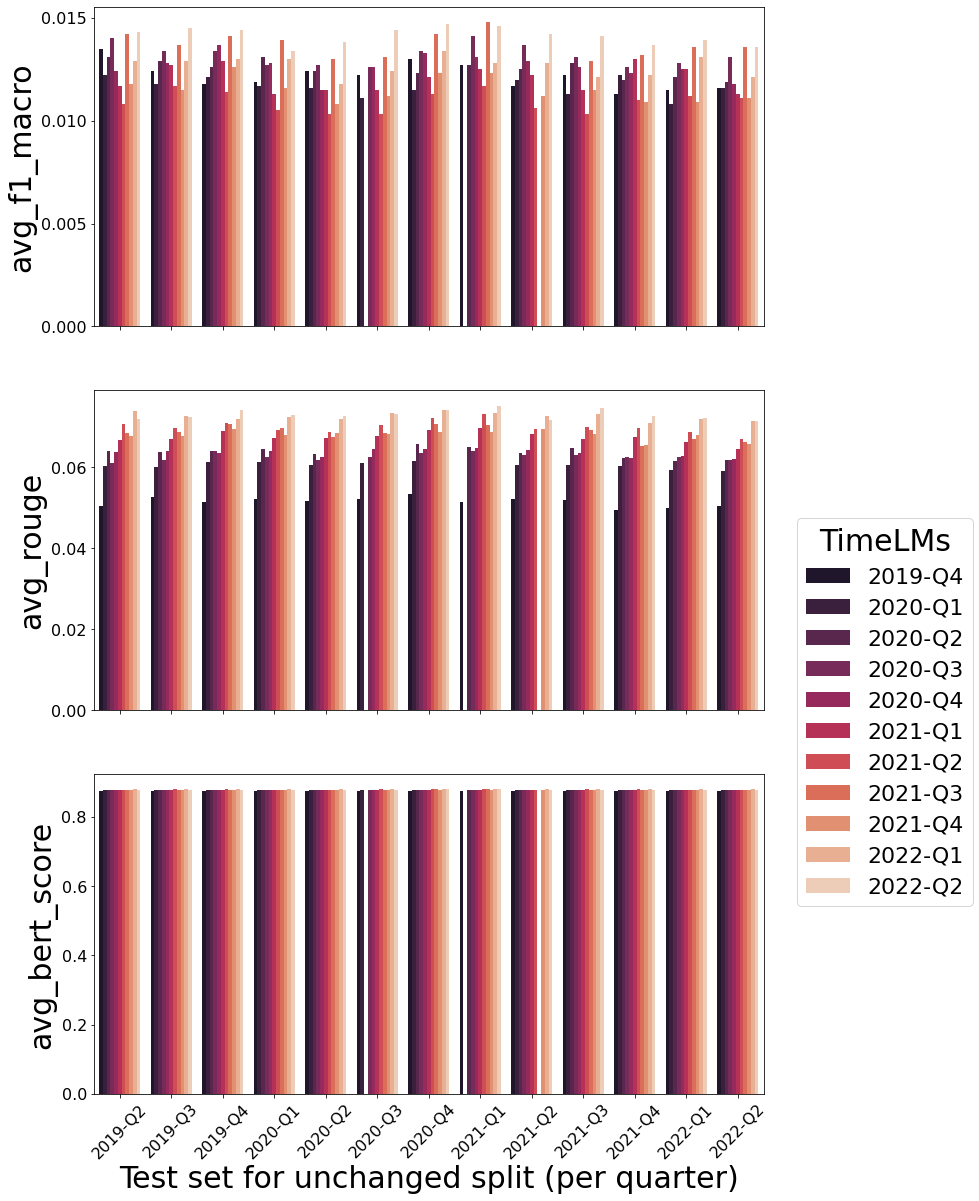

In [13]:
# Load all updated csv files with unchanged split
split = "unchanged"
updated_df = pd.DataFrame()

for model in models:
    for quarter in quarters:
        exp_str = "{}_dynamic-templama_2019-1-1_to_2022-6-31_per_quarter_multi_token_42_10_100".format(model.split("-")[-1])
        filepath = "{}_{}_{}.csv".format(exp_str, split, quarter)
        try:
            _df = pd.read_csv(os.path.join(MLT_CSV_DIR, filepath))
            updated_df = updated_df.append(_df, ignore_index=True)
        except:
            print(model, quarter)

# keep only columns we care about
updated_df = change_model_column(updated_df)[['model', 'quarter', 'size', 'split', 
                                              'avg_f1_micro', 'avg_f1_macro',
                                             'avg_rouge', 'avg_bleu_uni', 'avg_bert_score']]

df_to_plot = updated_df.copy()
plot_for_split(df_to_plot, split)

In [20]:
full_df

,model,quarter,size,split,avg_f1_micro,avg_f1_macro,avg_rouge,avg_bleu_uni,avg_bert_score
0,2019-Q4,2019-Q2,174,updated,0.0168,0.0146,0.0459,0.0479,0.8776
1,2019-Q4,2019-Q3,259,updated,0.0104,0.0076,0.0548,0.0679,0.8768
2,2019-Q4,2019-Q4,157,updated,0.0000,0.0000,0.0325,0.0376,0.8755
3,2019-Q4,2020-Q1,311,updated,0.0138,0.0111,0.0316,0.0349,0.8741
4,2019-Q4,2020-Q2,94,updated,0.0064,0.0038,0.0303,0.0268,0.8734
...,...,...,...,...,...,...,...,...,...
564,2022-Q2,2021-Q2,10608,unchanged,0.0185,0.0142,0.0717,0.0714,0.8784
565,2022-Q2,2021-Q3,10302,unchanged,0.0187,0.0141,0.0745,0.0733,0.8786
566,2022-Q2,2021-Q4,10372,unchanged,0.0181,0.0137,0.0726,0.0721,0.8785
567,2022-Q2,2022-Q1,10344,unchanged,0.0182,0.0139,0.0721,0.0710,0.8784


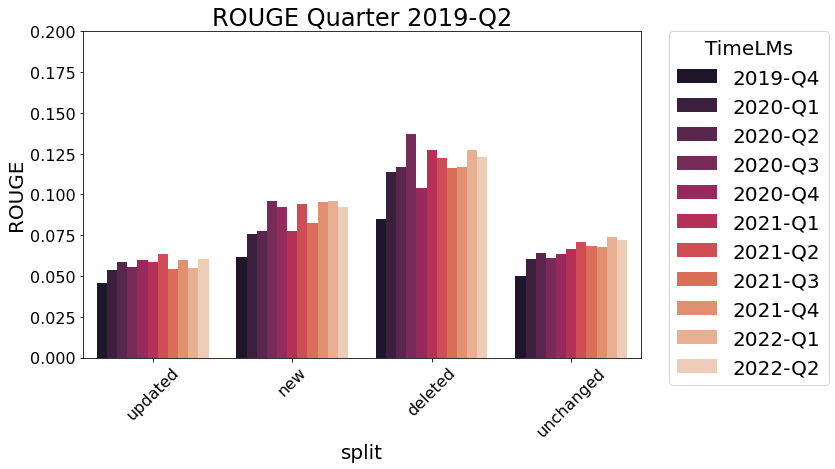

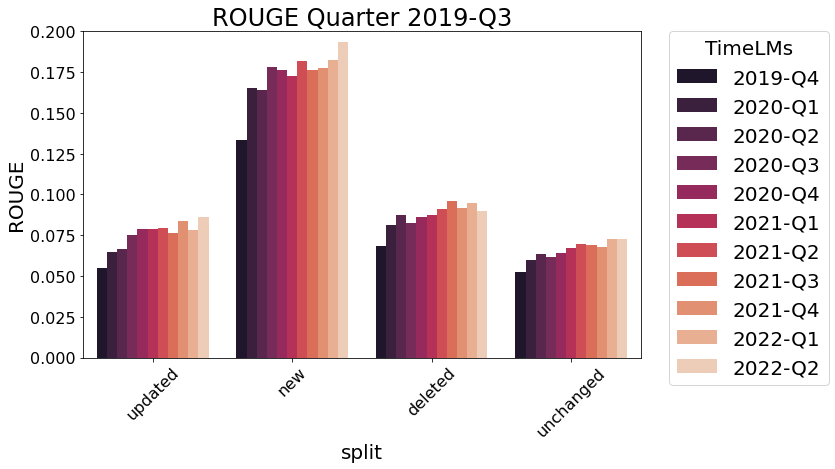

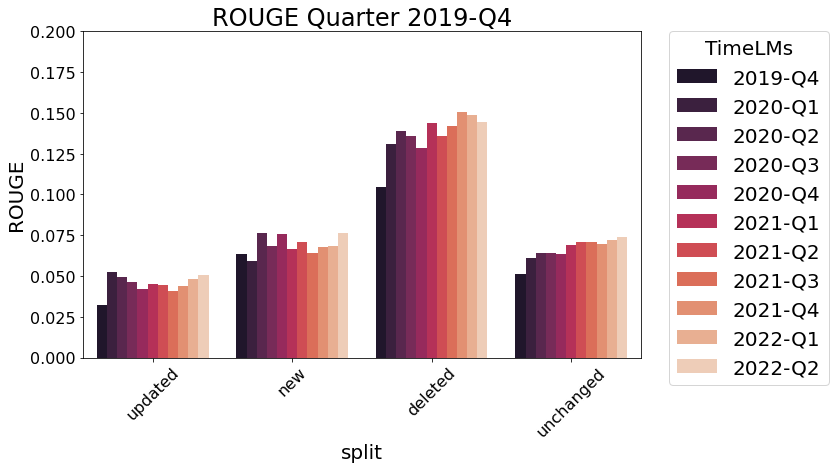

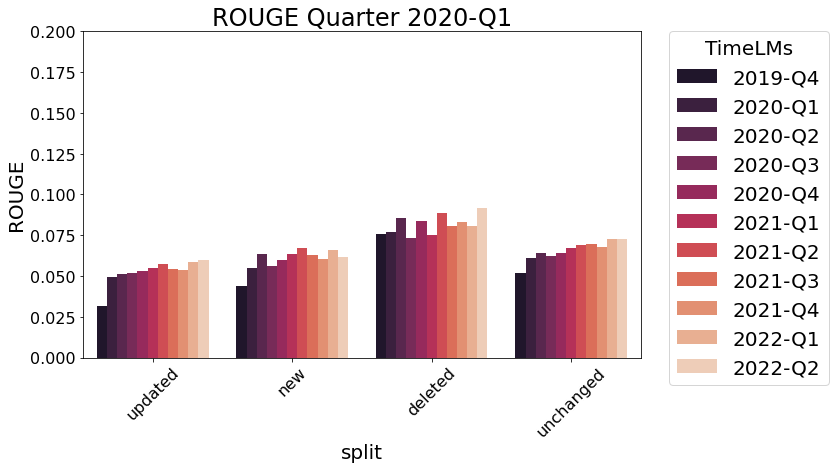

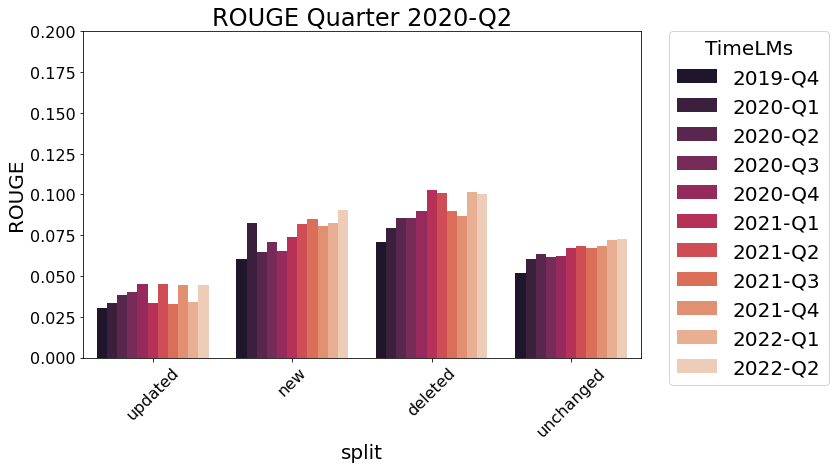

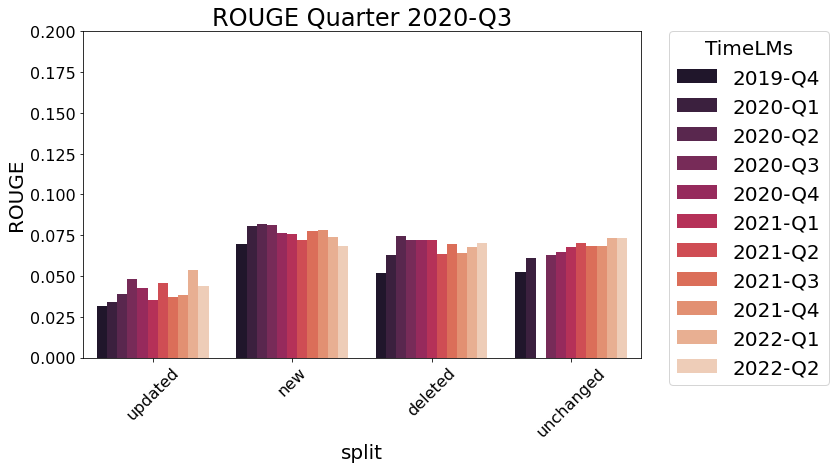

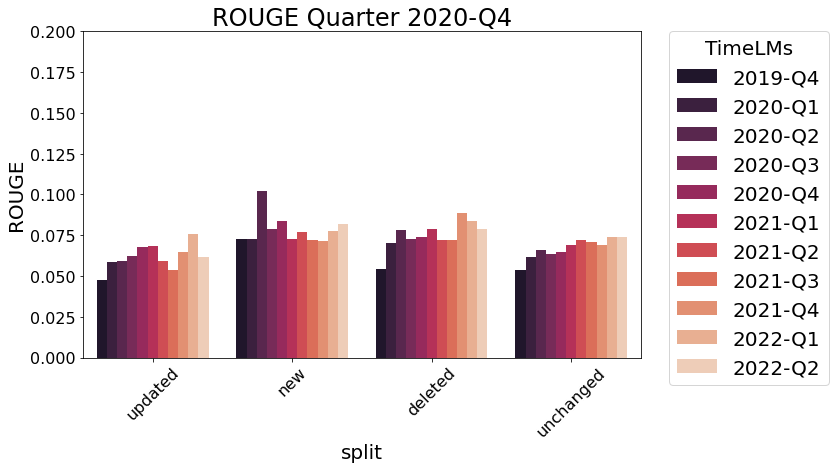

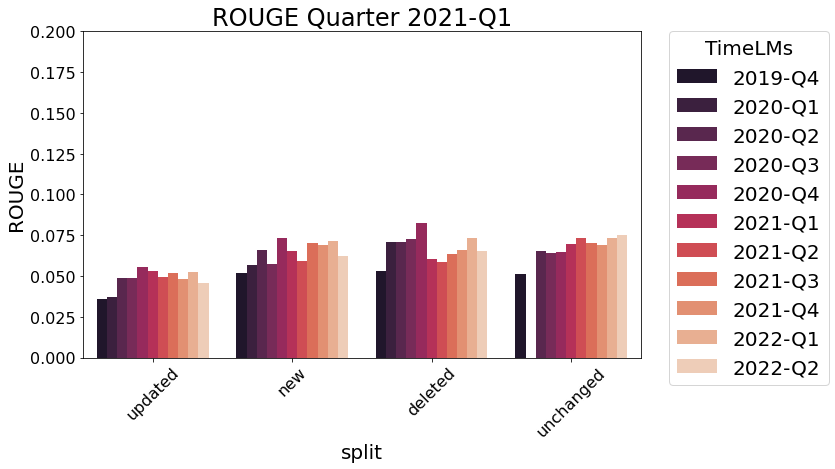

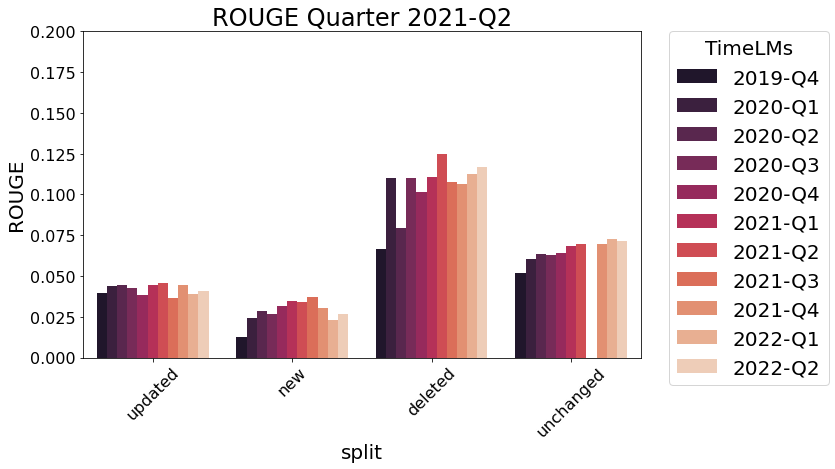

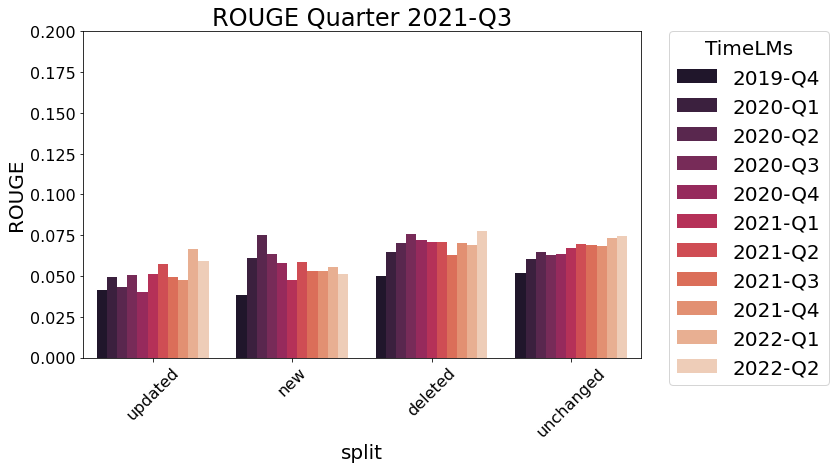

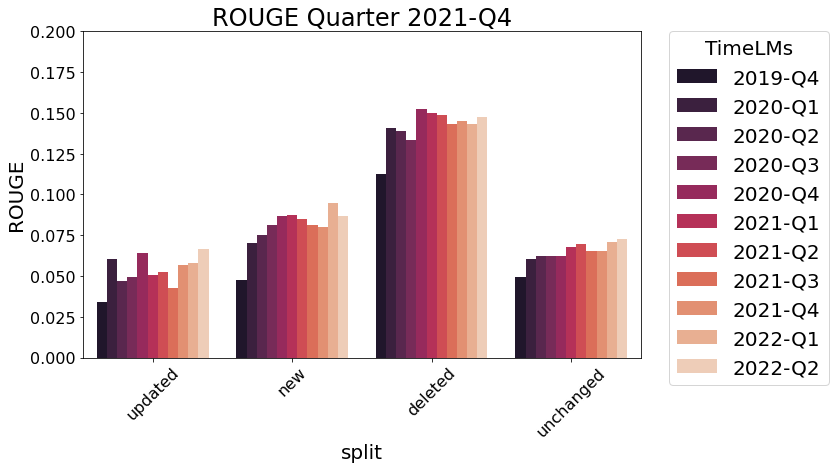

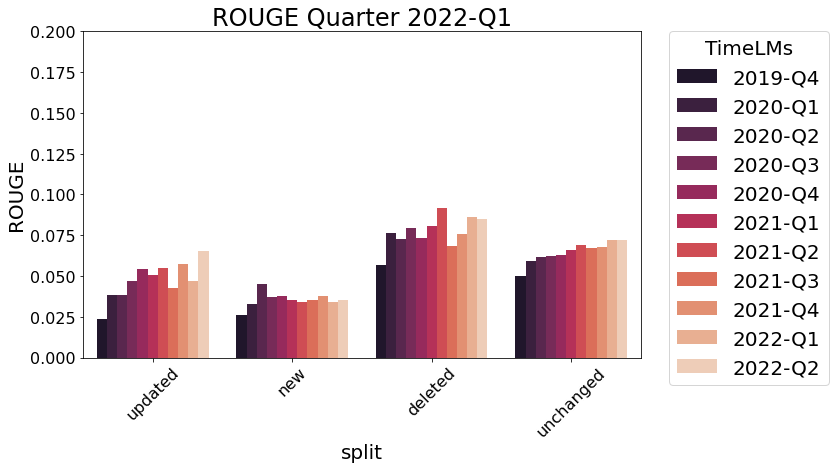

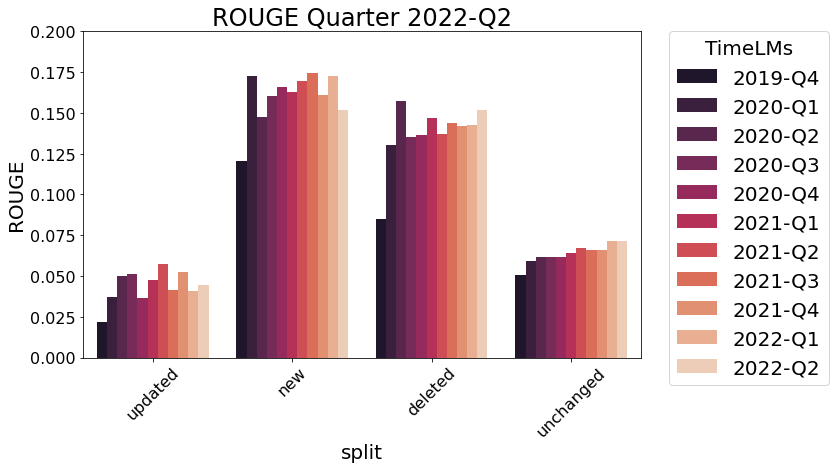

In [28]:
## Filter data
results_df = full_df
for quarter in sorted(list(set(results_df['quarter']))):
    _df = results_df[results_df['quarter']==quarter]
    fig, axs = plt.subplots(1,1, figsize=(10, 6), sharex=True)
    axs = [axs]
    # sns.barplot(x='year', y="P@1", data=results_df, hue='model', palette="rocket", ax=axs[0])
    sns.barplot(x='split', y="avg_rouge", data=_df, hue='model', palette="rocket")
    # sns.barplot(x='year', y="P@20", data=results_df, hue='model', palette="rocket", ax=axs[2])
    # sns.barplot(x='year', y="P@50", data=results_df, hue='model', palette="rocket", ax=axs[3])
    # sns.barplot(x='year', y="P@100", data=results_df, hue='model', palette="rocket", ax=axs[4])
    # [ax.get_legend().remove() for ax in axs[:-1]]
    # [ax.set_xlabel("") for ax in axs[:-1]]
    # axs[4].set_xlabel("Test split (year)")
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0, title='TimeLMs')
    for ax in axs:
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(16)
    plt.rcParams.update({'font.size': 20})
    plt.xticks(rotation=45)
    ax.set_ylim([0,0.2])
    plt.ylabel("ROUGE")
    plt.title("ROUGE Quarter {}".format(quarter))
    plt.savefig('plots/Rouge_per_quarter_all_models_{}.png'.format(quarter), bbox_inches = 'tight',edgecolor='white',dpi=500)

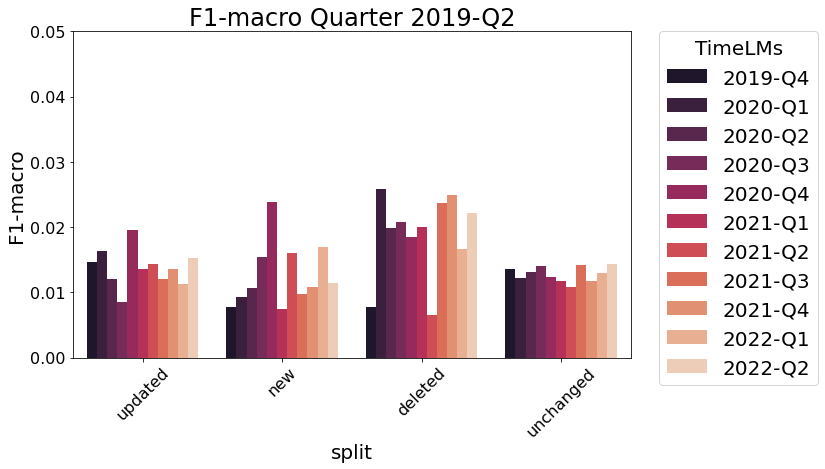

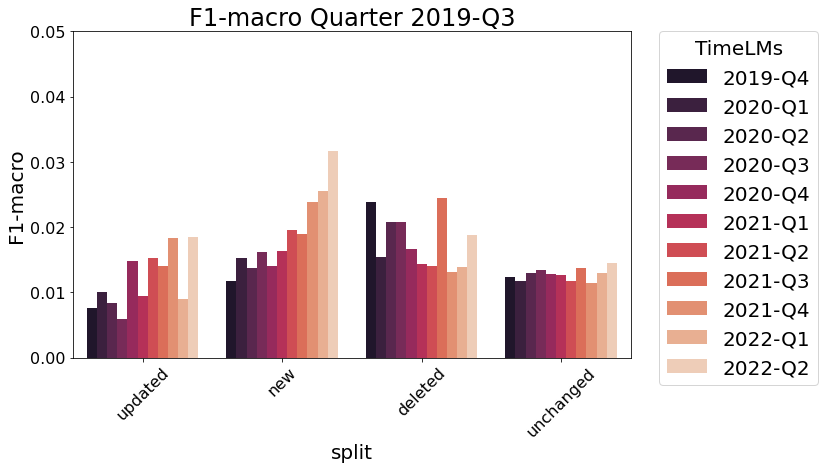

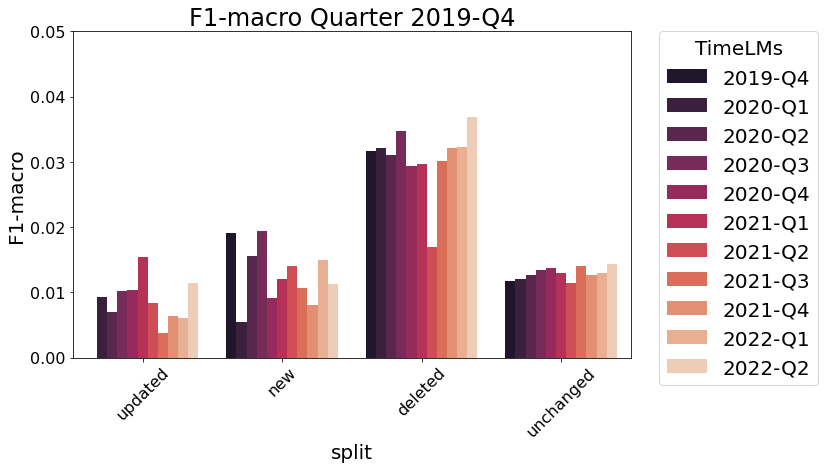

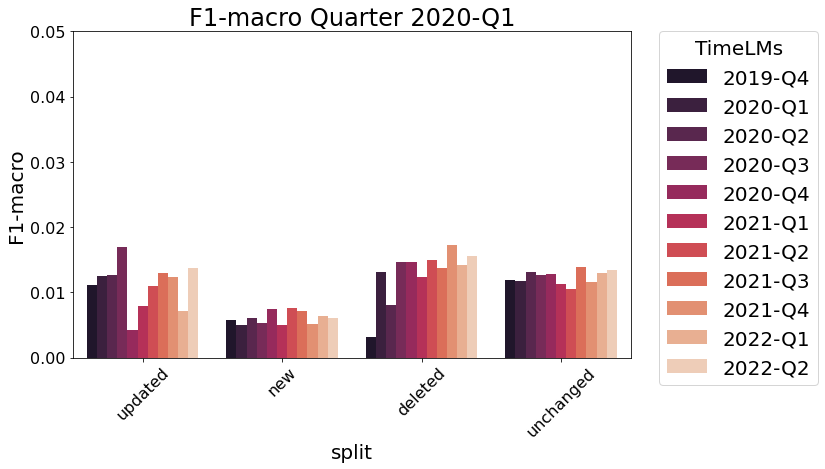

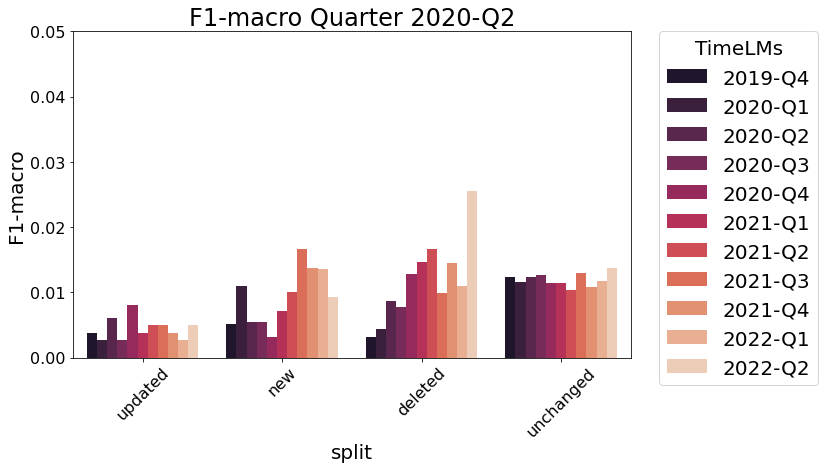

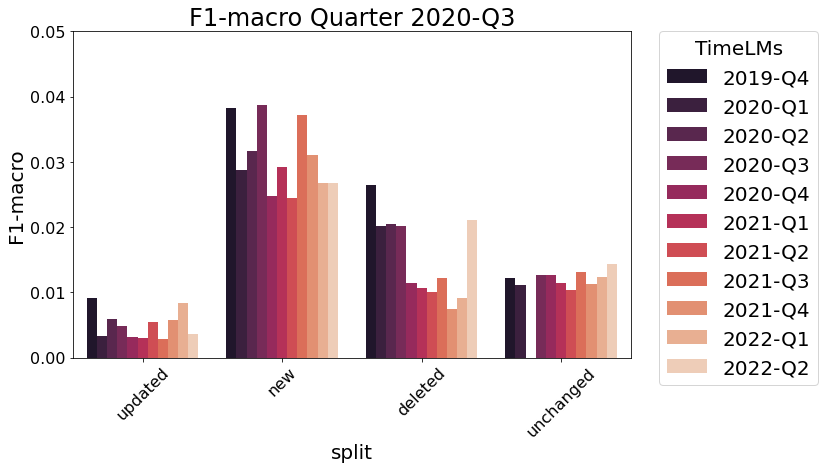

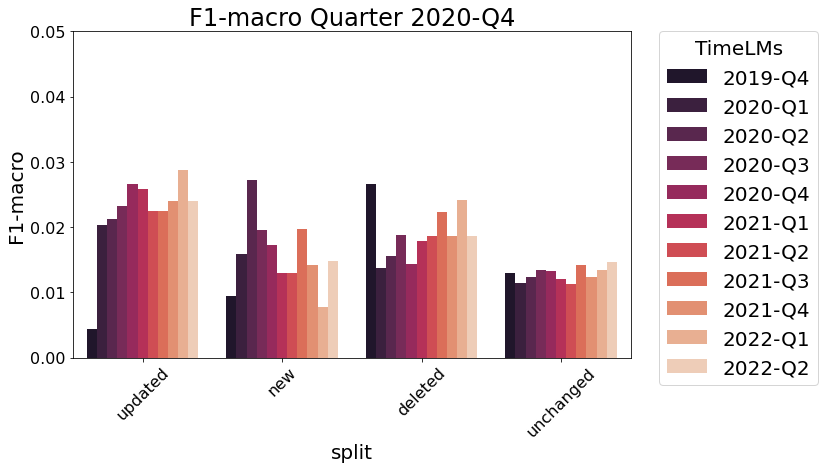

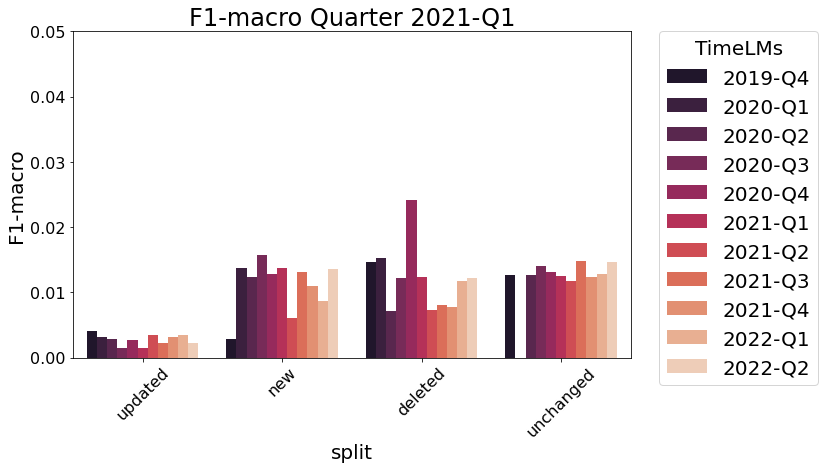

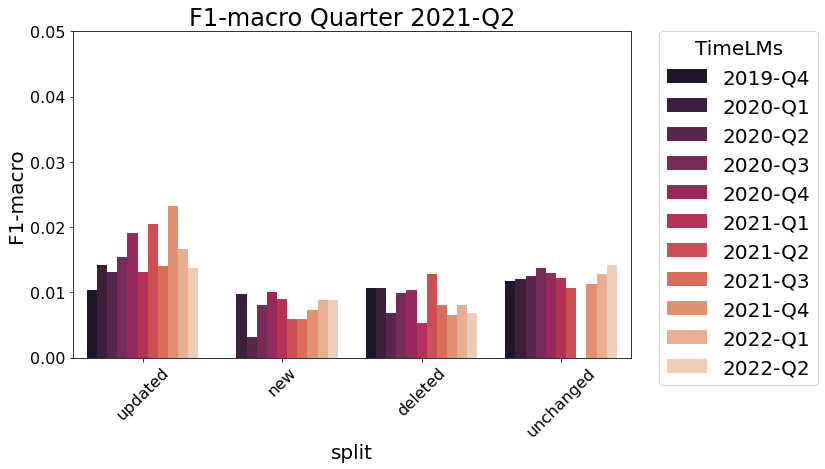

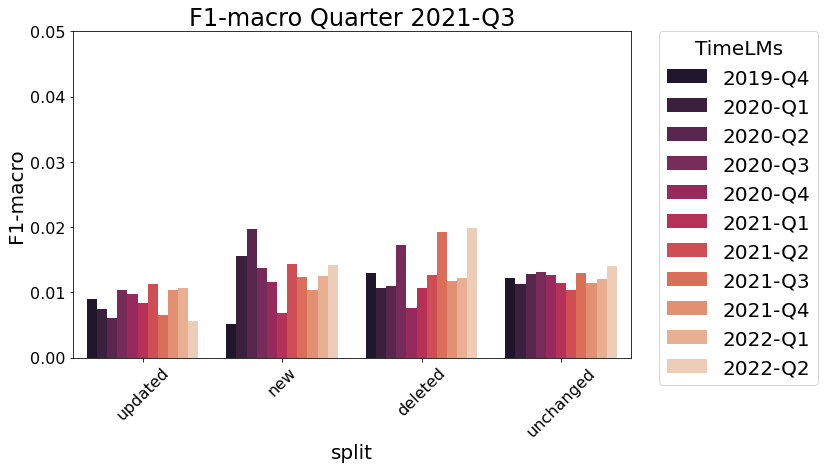

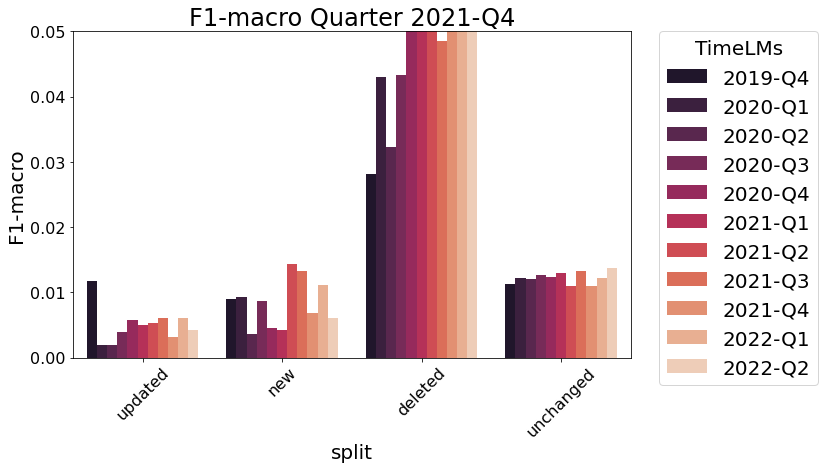

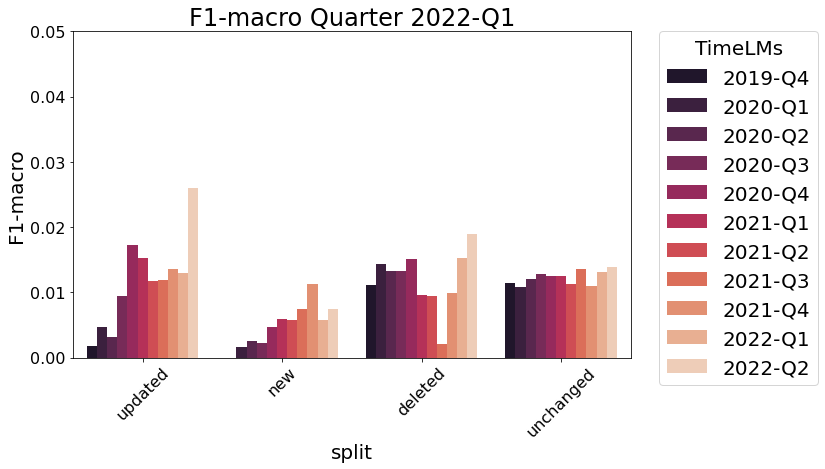

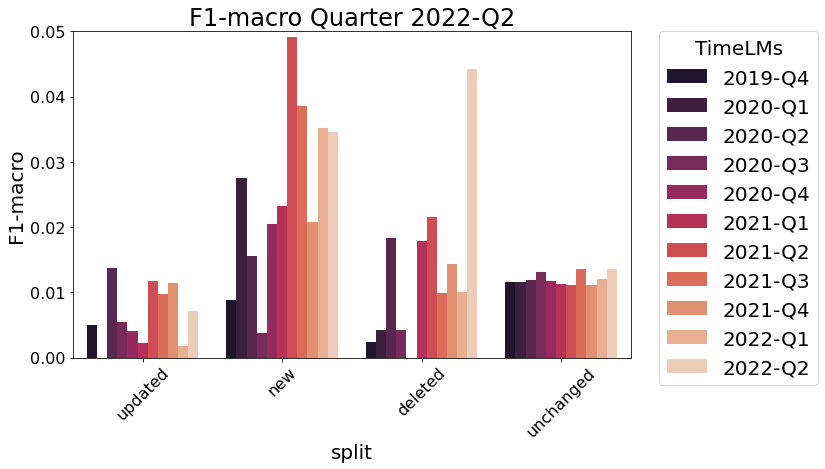

In [30]:
## Filter data
results_df = full_df
for quarter in sorted(list(set(results_df['quarter']))):
    _df = results_df[results_df['quarter']==quarter]
    fig, axs = plt.subplots(1,1, figsize=(10, 6), sharex=True)
    axs = [axs]
    # sns.barplot(x='year', y="P@1", data=results_df, hue='model', palette="rocket", ax=axs[0])
    sns.barplot(x='split', y="avg_f1_macro", data=_df, hue='model', palette="rocket")
    # sns.barplot(x='year', y="P@20", data=results_df, hue='model', palette="rocket", ax=axs[2])
    # sns.barplot(x='year', y="P@50", data=results_df, hue='model', palette="rocket", ax=axs[3])
    # sns.barplot(x='year', y="P@100", data=results_df, hue='model', palette="rocket", ax=axs[4])
    # [ax.get_legend().remove() for ax in axs[:-1]]
    # [ax.set_xlabel("") for ax in axs[:-1]]
    # axs[4].set_xlabel("Test split (year)")
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0, title='TimeLMs')
    for ax in axs:
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(16)
    plt.rcParams.update({'font.size': 20})
    plt.xticks(rotation=45)
    ax.set_ylim([0,0.05])
    plt.ylabel("F1-macro")
    plt.title("F1-macro Quarter {}".format(quarter))
    plt.savefig('plots/F1_macro_per_quarter_all_models_{}.png'.format(quarter), bbox_inches = 'tight',edgecolor='white',dpi=500)

********

# Up to here / Delete below

******

In [14]:
for split in list(set(results_df['split'])):
    _df = results_df[results_df['split']==split]
    fig, axs = plt.subplots(1,1, figsize=(10, 6), sharex=True)
    axs = [axs]
    # sns.barplot(x='year', y="P@1", data=results_df, hue='model', palette="rocket", ax=axs[0])
    sns.barplot(x='quarter', y="avg_f1_macro", data=_df, hue='model', palette="rocket")
    # sns.barplot(x='year', y="P@20", data=results_df, hue='model', palette="rocket", ax=axs[2])
    # sns.barplot(x='year', y="P@50", data=results_df, hue='model', palette="rocket", ax=axs[3])
    # sns.barplot(x='year', y="P@100", data=results_df, hue='model', palette="rocket", ax=axs[4])
    # [ax.get_legend().remove() for ax in axs[:-1]]
    # [ax.set_xlabel("") for ax in axs[:-1]]
    # axs[4].set_xlabel("Test split (year)")
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', borderaxespad=0, )
    for ax in axs:
        for label in (ax.get_xticklabels() + ax.get_yticklabels()):
            label.set_fontsize(16)
    plt.rcParams.update({'font.size': 20})
    plt.xticks(rotation=45)
    plt.title("MRR for {}".format(split))
    plt.savefig('plots/MRR_quarters_all_models_{}.png'.format(split), bbox_inches = 'tight',edgecolor='white',dpi=500)

NameError: name 'results_df' is not defined

In [ ]:
# boxplot_vis("P@1", results_df)

In [ ]:
# boxplot_vis("P@1", last_4_years_df)

In [ ]:
# boxplot_vis("P@10", last_4_years_df)

In [ ]:
# boxplot_vis("P@20", last_4_years_df)

In [ ]:
# boxplot_vis("P@50", last_4_years_df)

In [ ]:
# boxplot_vis("P@100", last_4_years_df)

In [ ]:
# fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14, 4), sharey=True)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(14, 4), sharex=True)
sns.lineplot(
    data=results_df,
    x="quarter", 
    y="avg_f1_macro",
    hue="model", 
    palette="rocket",
    ax=ax1,
    legend=False
)
ax2.set_ylabel("ROUGE")
sns.lineplot(
    data=results_df,
    x="quarter", 
    y="avg_rouge",
    hue="model", 
    palette="rocket",
    ax=ax2,
    legend=False
)
ax3.set_ylabel("BERt-score")
sns.lineplot(
    data=results_df,
    x="quarter", 
    y="avg_bert_score",
    hue="model", 
    palette="rocket",
    ax=ax3
)
ax3.legend(bbox_to_anchor=(1.25, 1), loc='upper left', borderaxespad=0, title='TimeLMs', prop={'size': 12})
for ax in axs:
#     ax.tick_params(bottom='off')
    ax.tick_params(axis='x', rotation=45)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(10)
#     ax.tick_params(labelrotation=45)
#     for tick in ax.get_xticklabels():
#         tick.set_rotation(45)
    ax.set_xticklabels(ax.get_xticks(), rotation = 45)
plt.rcParams.update({'font.size': 10})
# plt.xticks(rotation = 45)
plt.xticks(rotation=45)
fig.tight_layout()
plt.savefig('plots/p_over_time_lineplot_quarter.png', bbox_inches = 'tight')

## This visualises the average performance (y axis) of all models (x axis) in all test data between 2019 and 2022.

In [ ]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4,1, figsize=(8, 13), sharex=True)
# sns.set_theme(style="ticks")
sns.violinplot(data=results_df, y='avg_f1_macro', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax0)
sns.violinplot(data=results_df, y='avg_rouge', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax1)
sns.violinplot(data=results_df, y='avg_bleu_uni', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax2)
sns.violinplot(data=results_df, y='avg_bert_score', x='model',palette="rocket", bw=.2, cut=1, linewidth=1, ax=ax3)
plt.xticks(rotation=45)
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
ax0.set_xlabel("")
ax1.set_xlabel("")
ax2.set_xlabel("")
ax3.set_xlabel("TimeLMs")
ax0.set_title('Performance of TimeLMs *on average* across the last 4 years (2019-2022).')
plt.savefig('plots/Results_avg_last4years_quarter_multi_token.png', bbox_inches = 'tight', dpi=500)

## We can also explore the logs and predictions for every model in every split individually. For example:

In [ ]:
split = "updated"
model = "twitter-roberta-base-2019-90m"
seed = 42
N = 100
M = 5
topk = 20

In [ ]:
full_log_filename = "full_results_{}_2020-Q2_{}_{}_{}_{}.pt".format(model, split, N, M, seed)

In [ ]:
# for full log open
ddict = torch.load(os.path.join(RES_DIR, full_log_filename))
columns = ['text', 'gold_label', 
           'gold_num_masks', 'relation', 
           'num_answers', 'f1_micro', 'f1_macro', 'rouge', 
#            'bleu', 'bleu_uni_precision', 
           'bert_score', 
           'best_log_probs', 
           'best_pred_tokens', 
           'best_pred_strings']
dddict = {key: ddict[key] for key in columns}

In [ ]:
df = pd.DataFrame(data=dddict)

In [ ]:
df